In [1]:
import scipy.cluster.hierarchy as sch
import numpy as np
import pandas as pd
import pyfolio as pf
import quantstats as qs
from datetime import date
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import cvxopt as opt
from cvxopt import blas, solvers
import ffn
import config
from numpy.linalg import inv

/home/aj/.local/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
import seaborn as sns 
from pandas_datareader import data as web
import warnings
warnings.filterwarnings('ignore')

In [3]:
# On 20151227 by MLdP <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp


def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar


def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()


def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist


def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

In [4]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

In [5]:
def cov2cor(X):
    D = np.zeros_like(X)
    d = np.sqrt(np.diag(X))
    np.fill_diagonal(D, d)
    DInv = np.linalg.inv(D)
    R = np.dot(np.dot(DInv, X), DInv)
    return R

In [6]:
symbols = ['PG', 'MSFT', 'JPM', 'TMF', 'UPRO']

In [7]:
def get_symbols(symbols,data_source,ohlc,begin_date=None,end_date=None):
    out = []
    new_symbols = []
    for symbol in symbols:
        df = web.DataReader(symbol, data_source,begin_date, end_date)\
        [['High','Low','Open','Close','Volume','Adj Close']]
        new_symbols.append(symbol) 
        out.append(df[ohlc].astype('float'))
        data = pd.concat(out, axis = 1)
        data.columns = new_symbols
    return data

In [8]:
start = pd.Timestamp('2014-01-01')

end = pd.Timestamp('2020-01-06')

In [9]:
prices = get_symbols(symbols,data_source='yahoo',ohlc='Close',\
                     begin_date=start,end_date=end)

SPY = get_symbols('SPY',data_source='yahoo',ohlc='Close',\
                     begin_date=start,end_date=end)

In [10]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1514 entries, 2014-01-02 to 2020-01-07
Data columns (total 5 columns):
PG      1514 non-null float64
MSFT    1514 non-null float64
JPM     1514 non-null float64
TMF     1514 non-null float64
UPRO    1514 non-null float64
dtypes: float64(5)
memory usage: 71.0 KB


In [11]:
rets = prices.pct_change().fillna(0)
rets.head()

,PG,MSFT,JPM,TMF,UPRO
Date,,,,,
2014-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-03,-0.001118,-0.006728,0.007731,0.000454,-0.001710
2014-01-06,0.002362,-0.021132,0.005796,0.009532,-0.006638
2014-01-07,0.009673,0.007750,-0.011525,0.008543,0.017353
2014-01-08,-0.014493,-0.017852,0.009431,-0.007356,0.001059


In [12]:
pricesx = prices.copy()
pricesx['SPY'] = SPY.Y
pricesx.head()

retx = pricesx.pct_change().dropna()

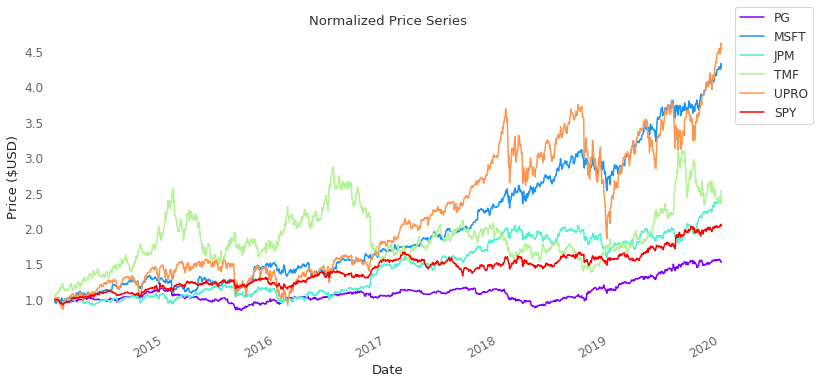

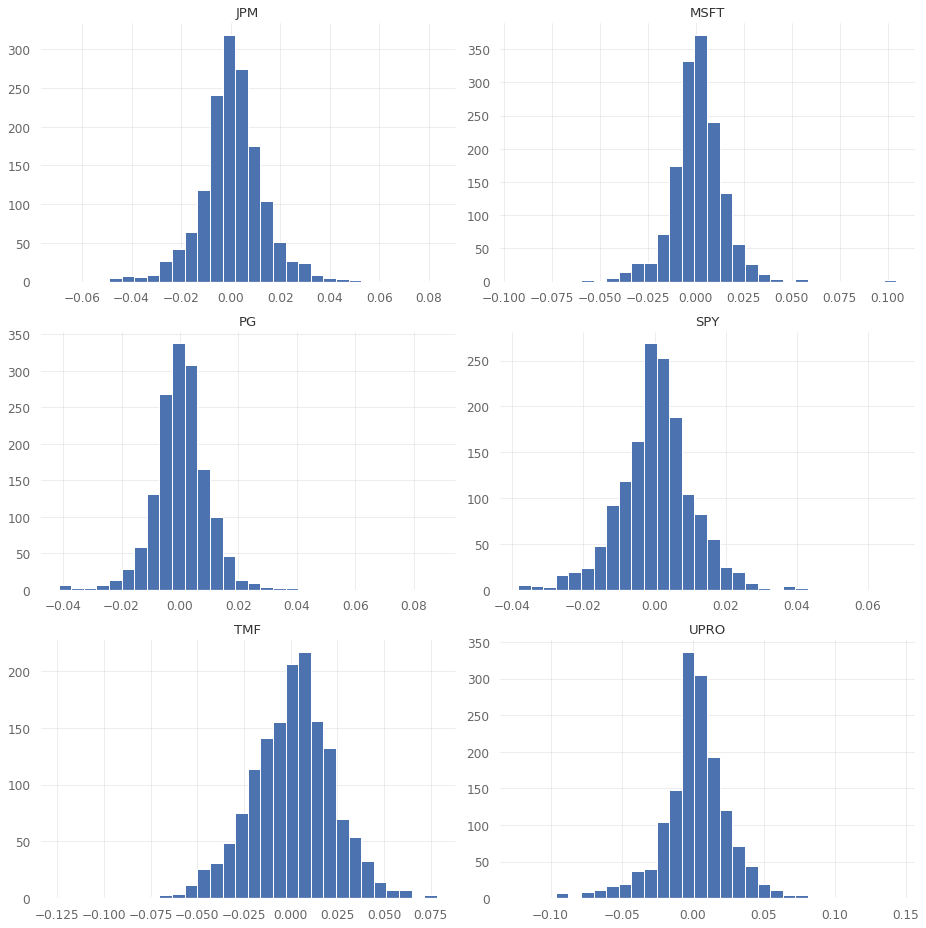

In [13]:
n_secs = len(pricesx.columns)
colors = cm.rainbow(np.linspace(0, 1, n_secs))
pricesx.div(pricesx.iloc[0,:]).plot(color=colors, figsize=(12, 6))# Normalize Prices 
plt.title('Normalized Price Series')
plt.xlabel('Date')
plt.ylabel('Price ($USD)')
plt.grid(b=None, which=u'major', axis=u'both')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

pricesx.pct_change().dropna().hist(bins=30, figsize=(13,13))
plt.tight_layout()
plt.show()

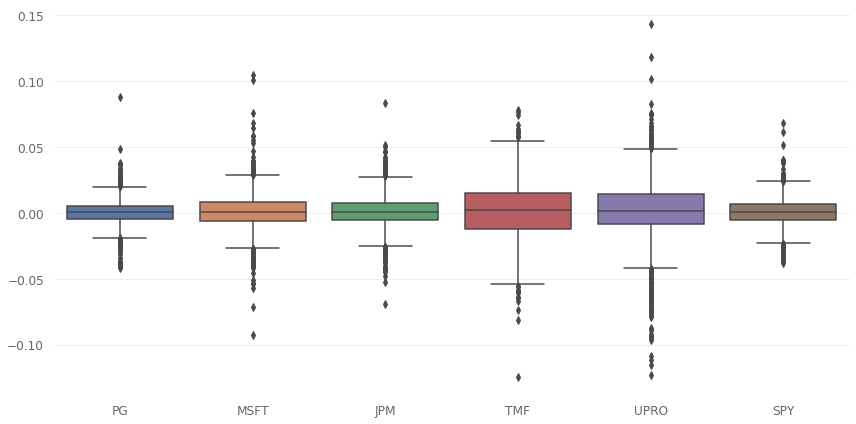

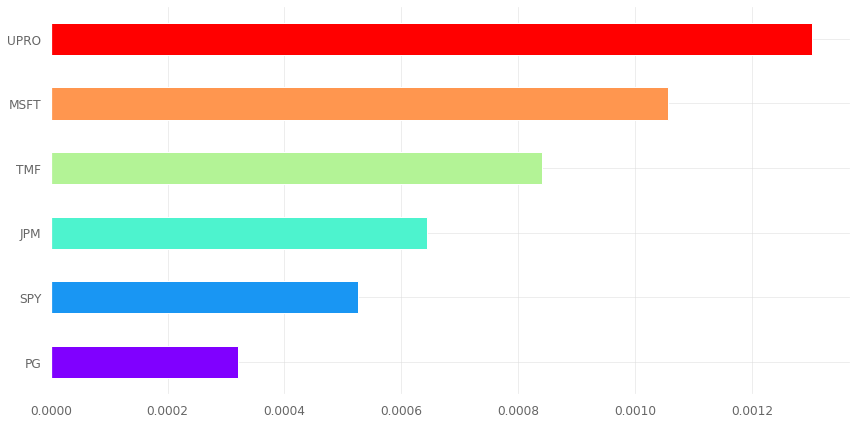

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(data=retx)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
retx.mean().sort_values(ascending=True).plot(kind='barh',colors=colors)
plt.tight_layout()
plt.show()

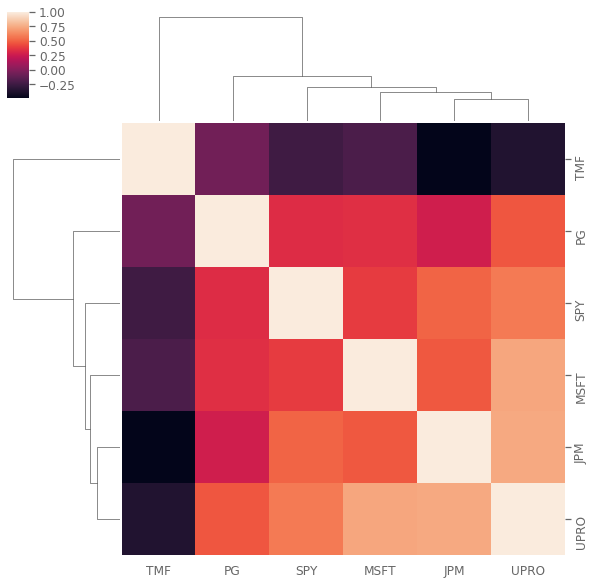

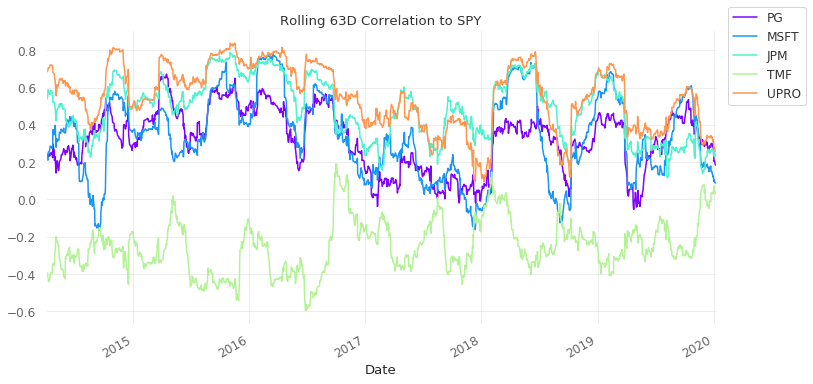

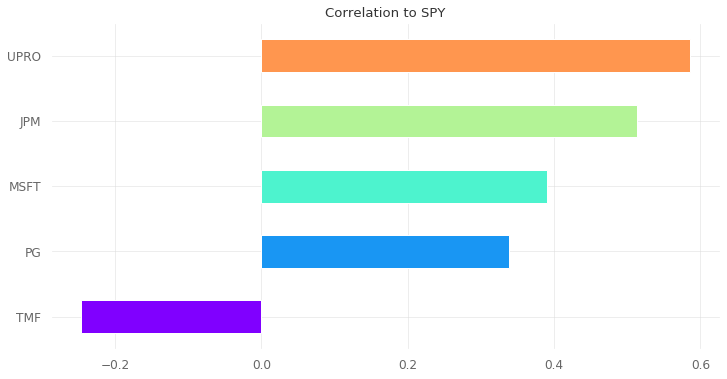

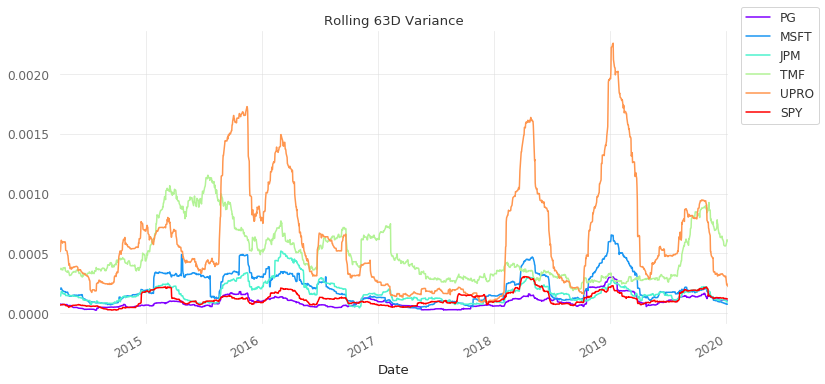

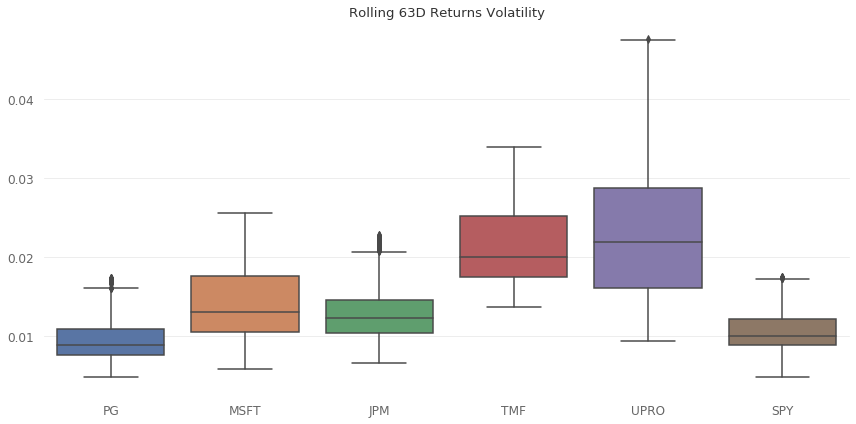

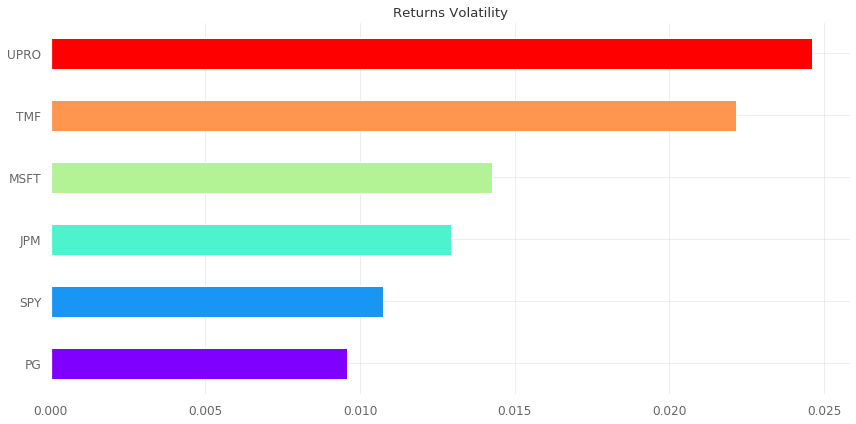

In [15]:
g = sns.clustermap(retx.corr())
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

retx.drop('SPY',axis=1).rolling(63).corr(retx.SPY).dropna().plot(color=colors, figsize=(12, 6))
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.title('Rolling 63D Correlation to SPY')
plt.show()

retx.drop('SPY',axis=1).corrwith(retx.SPY).sort_values(ascending=True).plot(kind='barh', color=colors, figsize=(12, 6))
plt.title('Correlation to SPY')
plt.show()

retx.rolling(63).var().dropna().plot(color=colors, figsize=(12, 6))
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.title('Rolling 63D Variance')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=retx.rolling(63).std().dropna())
plt.title('Rolling 63D Returns Volatility')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
retx.std().sort_values(ascending=True).plot(kind='barh',colors=colors)
plt.title('Returns Volatility')
plt.tight_layout()
plt.show()

In [24]:
X = retx[['PG', 'MSFT', 'JPM', 'TMF', 'UPRO']]
#X1 = retx[['UPRO', 'TMF', 'QQQ', 'XLK', 'XLF', 'DIA']]
y = retx['SPY']

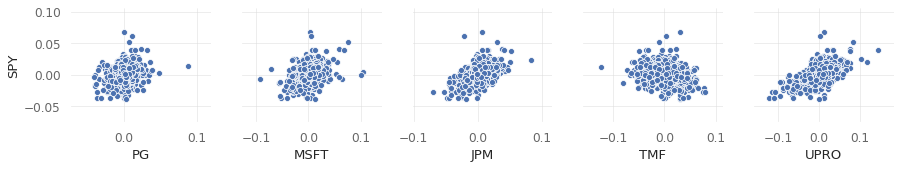

In [25]:
sns.pairplot(X.assign(SPY=y), y_vars=['SPY'], x_vars=X.columns)
plt.show();
#sns.pairplot(X1.assign(SPY=y), y_vars=['SPY'], x_vars=X1.columns)
#plt.show()

21d sliding window

In [16]:
MVP_Ret = []
IVP_Ret = []
HRP_Ret = []

MVP_Wt = []
IVP_Wt = []
HRP_Wt = []

X = rets
n_train = 21
n_records = len(X)

for i in range(n_train, n_records, 21):
    
    #train, test = X[0:i], X[i:i+21]
    train, test = X[i-n_train:i], X[i:i+21]
    
    print()
    print(f'Training on {len(train)} records', train)
    print()
    print(f'Testing on {len(test)} records', test)
    print()
    
    corr = train.corr()
    cov = train.cov()
    
    hrp = getHRP(cov, corr)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    portfolios = pd.DataFrame([mvp, ivp, hrp], index=['MVP', 'IVP', 'HRP']).T

    MVP_weights = portfolios.MVP.values
    IVP_weights = portfolios.IVP.values
    HRP_weights = portfolios.HRP.values

    MVP_Returns = test.mul(MVP_weights, axis=1)
    MVP_Returns = MVP_Returns.sum(axis=1)
    
    IVP_Returns = test.mul(IVP_weights, axis=1)
    IVP_Returns = IVP_Returns.sum(axis=1)

    HRP_Returns = test.mul(HRP_weights, axis=1)
    HRP_Returns = HRP_Returns.sum(axis=1)
    
    MVP_Ret.append(MVP_Returns)
    IVP_Ret.append(IVP_Returns)
    HRP_Ret.append(HRP_Returns)
    
    MVP_Wt.append(portfolios.MVP)
    IVP_Wt.append(portfolios.IVP)
    HRP_Wt.append(portfolios.HRP)
    
    wt11 = pd.concat(MVP_Wt, axis=1).T.reset_index(drop=True)
    wt21 = pd.concat(IVP_Wt, axis=1).T.reset_index(drop=True)
    wt31 = pd.concat(HRP_Wt, axis=1).T.reset_index(drop=True)

    data11 = pd.concat(MVP_Ret)
    data21 = pd.concat(IVP_Ret)
    data31 = pd.concat(HRP_Ret) 


Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
2014-01-10 -0.001492  0.014354 -0.004595  0.035817  0.008566
2014-01-13 -0.003611 -0.029412 -0.013507  0.015795 -0.038901
2014-01-14  0.010749  0.022870  0.000693 -0.014289  0.031202
2014-01-15 -0.000989  0.027390  0.030308 -0.001705  0.016610
2014-01-16 -0.002847  0.003536 -0.008405  0.017510 -0.004163
2014-01-17 -0.008441 -0.013825 -0.014918  0.012802 -0.012959
2014-01-21  0.003756 -0.005772  0.001032  0.002279  0.008788
2014-01-22 -0.011848 -0.006635 -0.009971 -0.006202  0.002204



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-04-03 -0.000374 -0.008222  0.002976  0.013002 -0.004860
2014-04-04 -0.004120 -0.027798 -0.014013  0.019349 -0.034772
2014-04-07  0.009026 -0.001756 -0.013543  0.019169 -0.034305
2014-04-08  0.010685  0.000503 -0.002542  0.005716  0.013308
2014-04-09  0.001721  0.016323  0.007137 -0.013201  0.032161
2014-04-10 -0.004909 -0.027428 -0.031551  0.027313 -0.063421
2014-04-11 -0.004069 -0.003811 -0.036585  0.023151 -0.027172
2014-04-14  0.000619 -0.000765 -0.006148 -0.006717  0.023312
2014-04-15  0.000371  0.014548 -0.002911  0.016373  0.020632
2014-04-16  0.010020  0.016352  0.008394  0.005428  0.031480
2014-04-17  0.001347 -0.009654 -0.000724 -0.033786  0.003879
2014-04-21 -0.002446 -0.001750 -0.003441 -0.002343  0.011388
2014-04-22 -0.003801  0.001252  0.014174  0.011382  0.012466
2014-04-23 -0.010954 -0.007502  0.004300  0.016792 -0.006156



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-07-03  0.005279 -0.002387  0.001404 -0.009829  0.015075
2014-07-07  0.002626  0.004546 -0.006661  0.020899 -0.009901
2014-07-08  0.004614 -0.005001 -0.016058  0.033095 -0.019068
2014-07-09  0.013779 -0.002633  0.004663  0.002972  0.012527
2014-07-10 -0.000735  0.000480 -0.008211  0.000165 -0.012031
2014-07-11 -0.005514  0.009595  0.004320  0.019095  0.004750
2014-07-14  0.001971  0.001188  0.008781 -0.013407  0.014011
2014-07-15 -0.000738  0.007356  0.035175 -0.005566 -0.005171
2014-07-16 -0.003938  0.038398  0.007551  0.016464  0.010907
2014-07-17 -0.006672  0.010209 -0.014478  0.037253 -0.034305
2014-07-18  0.001866  0.003593  0.006395 -0.008745  0.030462
2014-07-21 -0.003352  0.003356  0.000172  0.013863 -0.006099
2014-07-22 -0.002242 -0.000223  0.007383  0.006370  0.013465
2014-07-23 -0.001373  0.000892  0.005625 -0.004632  0.006727



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-10-02 -0.001082 -0.003050 -0.015560 -0.025089 -0.000621
2014-10-03  0.008910  0.007212  0.024813  0.011340  0.033135
2014-10-06 -0.002626  0.000000 -0.001990  0.001438 -0.003697
2014-10-07 -0.004906 -0.012150 -0.015121  0.041344 -0.045655
2014-10-08  0.012265  0.027454  0.019065  0.000414  0.052541
2014-10-09 -0.006177 -0.019880 -0.021854 -0.012540 -0.060658
2014-10-10  0.012312 -0.039695 -0.009479  0.029305 -0.034025
2014-10-13 -0.015586 -0.008630 -0.006152  0.018574 -0.049332
2014-10-14  0.002159  0.001833 -0.002923  0.018368  0.005179
2014-10-15 -0.007181 -0.011662 -0.042421  0.023657 -0.024376
2014-10-16 -0.008559 -0.011106 -0.008104 -0.017365 -0.000609
2014-10-17  0.012524  0.020824  0.020334 -0.015722  0.037602
2014-10-20  0.010928  0.010314  0.007651  0.008581  0.028306
2014-10-21  0.005108  0.018149  0.022956 -0.022906  0.059053



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-01-02 -0.007136  0.006674 -0.001438  0.030800 -0.002715
2015-01-05 -0.004755 -0.009196 -0.031045  0.048145 -0.053837
2015-01-06 -0.004555 -0.014677 -0.025929  0.053249 -0.027092
2015-01-07  0.005246  0.012705  0.001526 -0.005209  0.036882
2015-01-08  0.011436  0.029418  0.022346 -0.039322  0.052761
2015-01-09 -0.009330 -0.008405 -0.017387  0.033344 -0.024532
2015-01-12 -0.003657 -0.012503 -0.008595  0.016651 -0.024146
2015-01-13  0.004226 -0.005150  0.000170 -0.000102 -0.008221
2015-01-14 -0.003433 -0.008628 -0.034500  0.021569 -0.017535
2015-01-15 -0.001445 -0.010444 -0.032037  0.049099 -0.027341
2015-01-16  0.015468  0.016711  0.017094 -0.040061  0.037284
2015-01-20 -0.000658  0.003244 -0.003934  0.039953  0.007961
2015-01-21 -0.005044 -0.010132  0.003231 -0.033853  0.014679
2015-01-22  0.009809  0.026350  0.030417 -0.012106  0.045129



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-04-06  0.007400  0.031273 -0.000826 -0.016940  0.021313
2015-04-07 -0.007828 -0.000481  0.006284  0.024359 -0.008377
2015-04-08  0.004612 -0.002649  0.003287  0.000000  0.010596
2015-04-09  0.001450  0.001449  0.006880 -0.037799  0.013565
2015-04-10  0.005550  0.005786  0.003742  0.003669  0.015626
2015-04-13  0.000960  0.000959  0.005997  0.004731 -0.013035
2015-04-14  0.002038 -0.002634  0.015628  0.020869  0.005341
2015-04-15 -0.001077  0.014646  0.018560 -0.001992  0.013209
2015-04-16 -0.000120 -0.002366 -0.006230 -0.015336 -0.000921
2015-04-17 -0.011617 -0.012808 -0.015201  0.034457 -0.034537
2015-04-20  0.004120  0.030995  0.006365 -0.025884  0.027178
2015-04-21  0.002534 -0.006292 -0.014706 -0.013339 -0.003361
2015-04-22  0.000120  0.008208  0.010111 -0.047210  0.014566
2015-04-23 -0.025755  0.008141 -0.002224  0.013063  0.007567



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-07-06  0.001501 -0.000225 -0.002814  0.053534 -0.008128
2015-07-07  0.020862 -0.002027 -0.007872  0.028262  0.017878
2015-07-08 -0.008933 -0.001354 -0.020509  0.027068 -0.049473
2015-07-09 -0.004075  0.006329  0.010393 -0.059197  0.004928
2015-07-10  0.003595  0.002022  0.014219 -0.047694  0.038002
2015-07-13  0.011859  0.020847  0.015511 -0.009504  0.032625
2015-07-14  0.001587  0.001757  0.013952  0.008986  0.014010
2015-07-15  0.001341  0.003069  0.002173  0.031849 -0.001833
2015-07-16  0.001826  0.019668  0.005348  0.020772  0.022740
2015-07-17 -0.000729 -0.000857 -0.005032  0.016050  0.003176
2015-07-20 -0.000608  0.006435  0.000722 -0.012271  0.002065
2015-07-21 -0.006814  0.007673 -0.002310  0.015993 -0.012639
2015-07-22 -0.009800 -0.036802  0.014182  0.017850 -0.005983
2015-07-23 -0.001608  0.012516 -0.006279  0.037973 -0.016517



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-11-02  0.002880  0.011398  0.020078 -0.013047  0.035768
2015-11-03  0.005875  0.017092  0.003662 -0.023328  0.008597
2015-11-04  0.000130  0.004617  0.001064  0.003317 -0.007223
2015-11-05 -0.008695 -0.000368  0.008960 -0.008597 -0.004074
2015-11-06 -0.010734  0.009930  0.030403 -0.043356 -0.002046
2015-11-09 -0.002250 -0.013838 -0.015630 -0.016316 -0.027526
2015-11-10  0.004907 -0.012002  0.004303  0.007088  0.005270
2015-11-11  0.002508  0.002616 -0.004876 -0.005912 -0.010783
2015-11-12 -0.017114 -0.006151 -0.020045  0.013735 -0.041332
2015-11-13 -0.009376 -0.009002 -0.006667  0.017600 -0.033797
2015-11-16  0.018118  0.017600  0.014491 -0.002883  0.045276
2015-11-17 -0.003054 -0.014878 -0.005713  0.004405 -0.003440
2015-11-18  0.011056  0.016613  0.019961  0.007127  0.048015
2015-11-19  0.004216  0.001671  0.003114  0.018917 -0.001497



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-02-03  0.010970 -0.015849  0.006663 -0.023929  0.016800
2016-02-04 -0.004932 -0.003067  0.017244  0.014553  0.004327
2016-02-05  0.006196 -0.035385 -0.011130  0.004303 -0.057188
2016-02-08  0.017488 -0.014952 -0.020952  0.062074 -0.041130
2016-02-09  0.000242 -0.002631 -0.006013  0.005172 -0.000217
2016-02-10 -0.012343  0.008726 -0.012100  0.025625 -0.001083
2016-02-11 -0.021073 -0.000402 -0.044128  0.019667 -0.036226
2016-02-12  0.013642  0.016301  0.083286 -0.048120  0.058519
2016-02-16  0.005927  0.011683  0.014959 -0.031118  0.049543
2016-02-17  0.012029  0.026032  0.007198 -0.018779  0.049635
2016-02-18 -0.005700 -0.004388 -0.016335  0.035341 -0.012353
2016-02-19 -0.002318 -0.007089  0.000173  0.002416 -0.000195
2016-02-22  0.004157  0.016017  0.012971 -0.001886  0.042025
2016-02-23 -0.003896 -0.027920 -0.041830  0.012282 -0.036391



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-05-04  0.006165  0.001808 -0.015825  0.015308 -0.017624
2016-05-05 -0.003676  0.001404 -0.005360  0.020386  0.000801
2016-05-06  0.010209  0.009011  0.005878 -0.012383  0.009763
2016-05-09 -0.000122 -0.006350 -0.006331  0.007691  0.003804
2016-05-10  0.004384  0.018973  0.013560  0.000523  0.036160
2016-05-11 -0.004001  0.000588 -0.003707  0.016825 -0.027431
2016-05-12  0.003165  0.009011 -0.000647 -0.013155 -0.000157
2016-05-13 -0.014319 -0.008348 -0.009228  0.029265 -0.026485
2016-05-16  0.004924  0.014683  0.007516 -0.026308  0.029620
2016-05-17 -0.012373 -0.025468  0.000000  0.003429 -0.027204
2016-05-18 -0.009551  0.005939  0.038599 -0.041736  0.001286
2016-05-19  0.004258 -0.009644 -0.010150  0.013185 -0.010594
2016-05-20 -0.002120  0.005962  0.001893  0.001707  0.018170
2016-05-23  0.002249 -0.011655 -0.000787  0.006176 -0.004939



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-08-03 -0.009106  0.006893  0.015868  0.002566  0.008982
2016-08-04  0.000931  0.007372 -0.001547  0.021004  0.003561
2016-08-05 -0.003138  0.009932  0.026952 -0.030599  0.024427
2016-08-08 -0.000233  0.001725 -0.003017  0.002764 -0.001998
2016-08-09  0.002682  0.002411 -0.003480  0.030500  0.001068
2016-08-10  0.003721 -0.003093 -0.008957  0.011649 -0.007200
2016-08-11  0.004866  0.004826  0.002757 -0.025333  0.014370
2016-08-12  0.003574 -0.006175 -0.002139  0.024678 -0.002913
2016-08-15 -0.000230  0.003107  0.006124 -0.028525  0.009295
2016-08-16 -0.005056 -0.011700 -0.000152 -0.006769 -0.016445
2016-08-17  0.004389  0.002089  0.002739  0.017437  0.005350
2016-08-18  0.005520  0.000695  0.000911  0.004524  0.007052
2016-08-19 -0.001487  0.000347 -0.001365 -0.016455 -0.004624
2016-08-22 -0.005269  0.000868 -0.000911  0.026327 -0.000265



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-11-01  0.000576 -0.002003 -0.004187  0.002915 -0.020144
2016-11-02 -0.001267 -0.006187 -0.004205  0.014120 -0.019090
2016-11-03 -0.001614 -0.003702 -0.004368 -0.024570 -0.013323
2016-11-04 -0.017552 -0.008445 -0.009067  0.026868 -0.004703
2016-11-07  0.017395  0.029126  0.031287 -0.025347  0.065854
2016-11-08  0.010397  0.000828  0.002147 -0.014262  0.013587
2016-11-09 -0.017494 -0.004961  0.045980 -0.124255  0.034006
2016-11-10 -0.034563 -0.024431  0.046416 -0.044704  0.006141
2016-11-11  0.007474  0.005451  0.000522 -0.017294 -0.006646
2016-11-14 -0.006939 -0.015249  0.036771 -0.018116  0.001911
2016-11-15  0.007470  0.012904 -0.001887  0.013179  0.023303
2016-11-16 -0.005142  0.013250 -0.024698  0.027575 -0.005061
2016-11-17 -0.001443  0.016597  0.008010 -0.044557  0.014590
2016-11-18 -0.012881 -0.004782 -0.003973 -0.008479 -0.006596



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-02-02  0.004924 -0.006449 -0.004238 -0.002212  0.001395
2017-02-03 -0.003988  0.008073  0.030618 -0.000554  0.020081
2017-02-06 -0.000114 -0.000628 -0.004703  0.018303 -0.004210
2017-02-07  0.006979 -0.003300 -0.000576  0.020152 -0.000686
2017-02-08  0.003636 -0.001419 -0.008764  0.040577  0.004002
2017-02-09  0.003849  0.011367  0.014425 -0.033864  0.017084
2017-02-10 -0.007894 -0.000937 -0.002294 -0.001593  0.011758
2017-02-13  0.003865  0.011250  0.013218 -0.010638  0.015274
2017-02-14 -0.005096 -0.002318  0.015995 -0.022581  0.012864
2017-02-15  0.037105 -0.000619  0.011501 -0.014852  0.014961
2017-02-16 -0.003622 -0.000155 -0.000662  0.018425 -0.001909
2017-02-17  0.003304  0.001550 -0.003314  0.016996  0.003931
2017-02-21  0.006367 -0.002012  0.008645 -0.005391  0.017251
2017-02-22 -0.002509 -0.002016  0.000549  0.004878 -0.001769



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-05-04  0.000231 -0.003909  0.001149 -0.014440  0.001917
2017-05-05  0.000578  0.002761 -0.001148  0.001046  0.012584
2017-05-08  0.000578 -0.000870  0.001149 -0.015159 -0.000597
2017-05-09 -0.001733  0.001451 -0.004018 -0.001062 -0.002686
2017-05-10  0.001042  0.003911  0.007839 -0.003188  0.004588
2017-05-11 -0.003700 -0.012264 -0.003088 -0.000533 -0.005461
2017-05-12  0.000232 -0.001169 -0.002754  0.021867 -0.004992
2017-05-15  0.001624  0.000731  0.004832 -0.006785  0.014850
2017-05-16 -0.001043  0.014321  0.003091  0.009984 -0.002175
2017-05-17  0.000232 -0.027806 -0.038124  0.043184 -0.052616
2017-05-18 -0.004521  0.003408 -0.003679  0.003491  0.010355
2017-05-19  0.004309 -0.000295  0.009767  0.007455  0.019462
2017-05-22 -0.000348  0.011228 -0.000944 -0.007400  0.016044
2017-05-23 -0.001508  0.003360  0.012515 -0.021869  0.006296



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-09-01  0.002818 -0.011101  0.008912 -0.021324  0.005445
2017-09-05  0.002053 -0.004463 -0.023882  0.045393 -0.022653
2017-09-06  0.000000 -0.002853  0.006703 -0.017369  0.010158
2017-09-07  0.002696  0.012806 -0.017534  0.030932 -0.000731
2017-09-08 -0.001398 -0.004843 -0.001243 -0.006429 -0.004208
2017-09-11  0.012387  0.010543  0.015494 -0.035807  0.031511
2017-09-12 -0.005107 -0.001070  0.012251 -0.016107  0.010955
2017-09-13  0.000428  0.007097  0.002861 -0.011369  0.001850
2017-09-14  0.000000 -0.005850 -0.001975  0.011500 -0.001407
2017-09-15 -0.002993  0.007222  0.007145  0.000910  0.004403
2017-09-18 -0.001287 -0.001992  0.014189 -0.016356  0.005348
2017-09-19  0.010950  0.003725  0.010977 -0.009238  0.002355
2017-09-20  0.002442 -0.006628  0.007026  0.003263  0.001566
2017-09-21 -0.018644 -0.009741  0.004545 -0.002788 -0.008513



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-12-01  0.004112  0.001069  0.002583  0.040720 -0.005462
2017-12-04  0.011620 -0.037740  0.020613  0.002730 -0.003860
2017-12-05 -0.000109  0.006290 -0.011501  0.013158 -0.010506
2017-12-06 -0.001641  0.014585 -0.007473  0.010748  0.000000
2017-12-07 -0.012603 -0.003503 -0.002954 -0.021267  0.009413
2017-12-08  0.002997  0.020245  0.012521 -0.002263  0.016039
2017-12-11 -0.001549  0.012714 -0.002926 -0.005445  0.009618
2017-12-12 -0.004212  0.004107  0.011645 -0.002281  0.004872
2017-12-13  0.011464 -0.002688 -0.012541  0.021491 -0.000579
2017-12-14  0.001320 -0.007733 -0.008056  0.013429 -0.012237
2017-12-15  0.009780  0.025505  0.014141  0.010159  0.024338
2017-12-18 -0.000109 -0.005412  0.007726 -0.027110  0.019108
2017-12-19 -0.002177 -0.006367 -0.004207 -0.039551 -0.011447
2017-12-20 -0.001636 -0.003612 -0.003474 -0.035564 -0.001776



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-04-05 -0.003163  0.000541  0.008019 -0.021534  0.020343
2018-04-06 -0.004695 -0.023273 -0.024937  0.032206 -0.065807
2018-04-09 -0.003443  0.005985  0.012008  0.004160  0.011955
2018-04-10  0.002687  0.023246  0.019112 -0.004661  0.047728
2018-04-11 -0.001276 -0.010982 -0.016799  0.009365 -0.014832
2018-04-12 -0.006133  0.018724  0.024860 -0.020619  0.023735
2018-04-13  0.007456 -0.005343 -0.027079  0.006842 -0.008703
2018-04-16  0.003062  0.011710 -0.000816 -0.000523  0.024069
2018-04-17 -0.002290  0.020176  0.000000  0.008368  0.032446
2018-04-18 -0.002933  0.003851 -0.008075 -0.025415  0.002076
2018-04-19 -0.041560 -0.003422  0.021954 -0.021820 -0.017502
2018-04-20 -0.015343 -0.011549 -0.002238 -0.023395 -0.025158
2018-04-23 -0.010840  0.003684 -0.004844  0.001114 -0.000448
2018-04-24 -0.006849 -0.023387 -0.004688 -0.015581 -0.040072



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-07-05  0.016816  0.007168  0.001062  0.010204  0.025107
2018-07-06  0.001262  0.014034  0.003278  0.009091  0.024074
2018-07-09 -0.018283  0.006821  0.030944 -0.019019  0.027596
2018-07-10  0.025173  0.002651 -0.006152  0.000510  0.010543
2018-07-11 -0.008269 -0.001371 -0.002157  0.010199 -0.021063
2018-07-12 -0.003411  0.021671  0.004324  0.000505  0.025538
2018-07-13  0.005324  0.011901 -0.004586  0.006559  0.001961
2018-07-16  0.002774 -0.004932  0.039677 -0.013033 -0.002153
2018-07-17  0.006287  0.009913 -0.000723 -0.006602  0.012551
2018-07-18 -0.003874 -0.007834  0.009321 -0.011247  0.005617
2018-07-19 -0.012418 -0.006849 -0.014705  0.018097 -0.011556
2018-07-20 -0.000635  0.017912  0.012649 -0.035551 -0.003507
2018-07-23 -0.002161  0.015997  0.018602 -0.036861  0.005866
2018-07-24  0.006114 -0.002871  0.007058  0.010388  0.013608



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-11-01  0.010262 -0.008333 -0.000367  0.001904  0.031298
2018-11-02  0.002456  0.002266 -0.005506 -0.036732 -0.019662
2018-11-05  0.015477  0.012717  0.006551  0.010519  0.018313
2018-11-06  0.003399  0.001953  0.004675 -0.001952  0.017983
2018-11-07 -0.002404  0.039361  0.017153  0.003259  0.063512
2018-11-08  0.000767 -0.001876  0.008073 -0.000650 -0.005932
2018-11-09  0.011493 -0.019508 -0.009699  0.023407 -0.027651
2018-11-12  0.003138 -0.024642 -0.021026  0.019695 -0.058101
2018-11-13  0.008306  0.000655  0.005874 -0.003738 -0.004996
2018-11-14  0.000214 -0.018422 -0.020622  0.003127 -0.021829
2018-11-15  0.003637  0.022006  0.025529 -0.001247  0.031913
2018-11-16 -0.000107  0.009415 -0.000727  0.016230  0.007137
2018-11-19 -0.005649 -0.033890  0.007637  0.008599 -0.048959
2018-11-20 -0.012756 -0.027815 -0.021474  0.001218 -0.056898



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2019-05-07 -0.009273 -0.020523 -0.016335  0.023902 -0.050009
2019-05-08  0.003534 -0.000080 -0.005300 -0.014292 -0.004645
2019-05-09 -0.007900 -0.000080 -0.000799  0.012083 -0.010111
2019-05-10  0.016980  0.012988 -0.000089 -0.003343  0.014143
2019-05-13  0.000943 -0.029733 -0.027198  0.022999 -0.073988
2019-05-14 -0.004806  0.011188  0.007949 -0.008899  0.025099
2019-05-15  0.010417  0.010342 -0.003807  0.017486  0.017343
2019-05-16  0.013215  0.023092  0.012830 -0.009289  0.027076
2019-05-17 -0.006105 -0.006670 -0.004851  0.006563 -0.018746
2019-05-20 -0.001117 -0.014445  0.005236 -0.006986 -0.019304
2019-05-21 -0.008944  0.005387  0.003413 -0.004690  0.025771
2019-05-22  0.003290  0.006068 -0.008145  0.015551 -0.008506
2019-05-23  0.000375 -0.011671 -0.019672  0.034339 -0.035914
2019-05-24 -0.000656  0.000475  0.009849  0.002243  0.003932



Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2019-08-06  0.010612  0.018758  0.007849  0.021701  0.038296
2019-08-07  0.010851  0.004380 -0.021733  0.002741  0.002170
2019-08-08  0.016621  0.026685  0.016940  0.005466  0.057469
2019-08-09 -0.005620 -0.008496 -0.001092 -0.004757 -0.020473
2019-08-12 -0.006422 -0.013942 -0.018772  0.061113 -0.036861
2019-08-13  0.010515  0.020694  0.015416 -0.009652  0.046163
2019-08-14 -0.012452 -0.033333 -0.041522  0.066277 -0.087686
2019-08-15  0.013818 -0.002239  0.003817  0.032907  0.007441
2019-08-16  0.015248  0.018327  0.023954 -0.024189  0.043701
2019-08-19  0.008894  0.016749  0.009005 -0.041717  0.035974
2019-08-20 -0.011144 -0.008309 -0.012697  0.029022 -0.023340
2019-08-21  0.002523  0.011147  0.002796 -0.019313  0.024286
2019-08-22  0.001846 -0.007277  0.010315 -0.019381 -0.001328
2019-08-23 -0.017585 -0.031862 -0.024834  0.048135 -0.077683


2020-01-03 -0.006726 -0.012452 -0.019491  0.044145 -0.021697

Testing on 2 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2020-01-06  0.001387  0.002585 -0.000795 -0.015407  0.010378
2020-01-07 -0.006191 -0.009118 -0.017001 -0.014920 -0.008724



21d sliding window

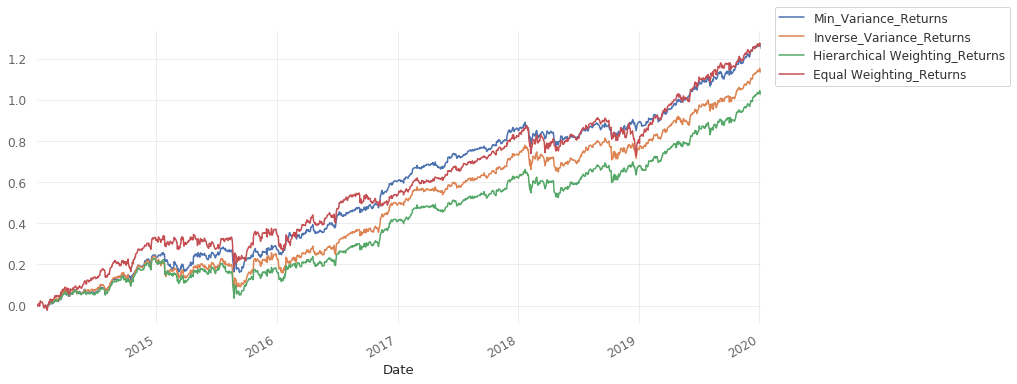

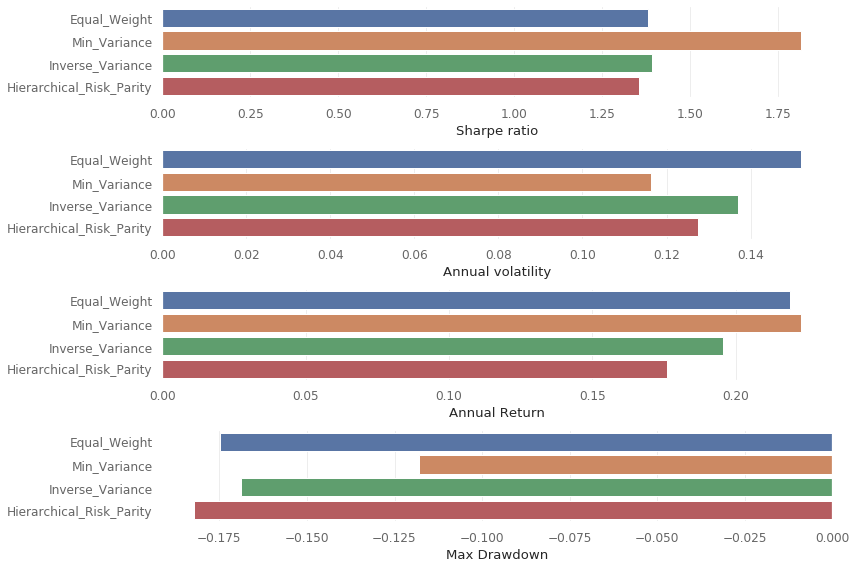

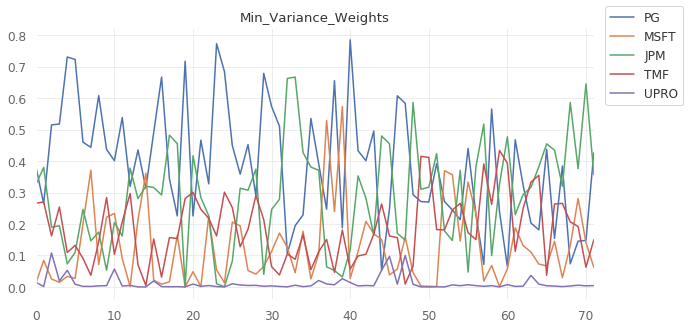

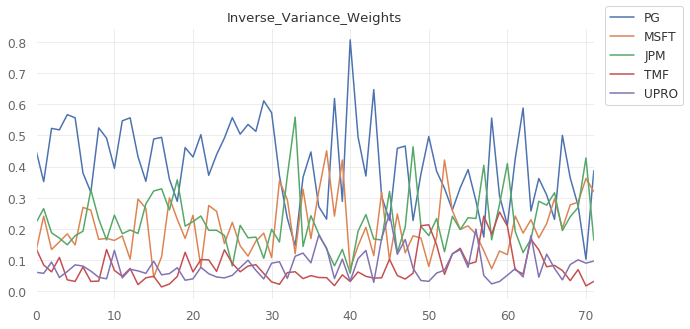

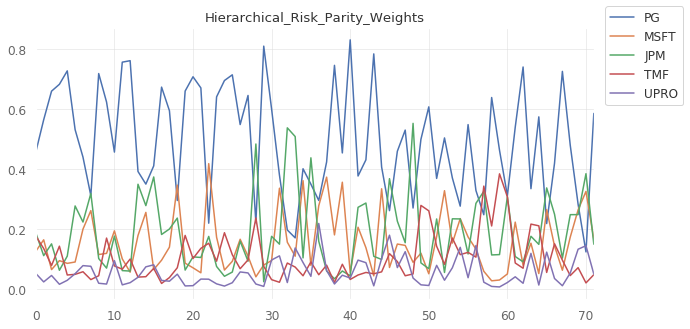

In [17]:
data = rets.copy()
data /= len(data.columns)
final_res = data.sum(axis=1)

port_returns = pd.concat([final_res, data11, data21, data31], axis=1)
port_returns.columns = ['Equal_Weight', 'Min_Variance', 'Inverse_Variance', 'Hierarchical_Risk_Parity']

plt.figure(figsize=(13,6))
data11.cumsum().plot(label='Min_Variance_Returns')
data21.cumsum().plot(label='Inverse_Variance_Returns')
data31.cumsum().plot(label='Hierarchical Weighting_Returns')
final_res.cumsum().plot(label='Equal Weighting_Returns')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

fig, axs = plt.subplots(nrows=4, figsize=(12, 8))
colors = sns.color_palette(palette='Set3', n_colors=len(port_returns))

sharpes = port_returns.apply(pf.timeseries.sharpe_ratio)
sns.barplot(x=sharpes.values, y=sharpes.index, ax=axs[0])
axs[0].set(xlabel='Sharpe ratio')

vols = port_returns.apply(pf.timeseries.annual_volatility)
sns.barplot(x=vols.values, y=vols.index, ax=axs[1])
axs[1].set(xlabel='Annual volatility')

aret = port_returns.apply(pf.timeseries.annual_return)
sns.barplot(x=aret.values, y=aret.index, ax=axs[2])
axs[2].set(xlabel='Annual Return')
fig.tight_layout()

mdd = port_returns.apply(pf.timeseries.max_drawdown)
sns.barplot(x=mdd.values, y=mdd.index, ax=axs[3])
axs[3].set(xlabel='Max Drawdown')
fig.tight_layout()
plt.show();

wt11.plot(figsize=(10,5))
plt.title('Min_Variance_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt21.plot(figsize=(10,5))
plt.title('Inverse_Variance_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt31.plot(figsize=(10,5))
plt.title('Hierarchical_Risk_Parity_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

expanding window

In [18]:
MVP_Ret = []
IVP_Ret = []
HRP_Ret = []

MVP_Wt = []
IVP_Wt = []
HRP_Wt = []

X = rets
n_train = 21
n_records = len(X)

for i in range(n_train, n_records, 21):
    
    train, test = X[0:i], X[i:i+21]
    #train, test = X[i-n_train:i], X[i:i+63]
    
    print()
    print(f'Training on {len(train)} records', train)
    print()
    print(f'Testing on {len(test)} records', test)
    print()
    
    corr = train.corr()
    cov = train.cov()
    
    hrp = getHRP(cov, corr)
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=cov.index)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    
    portfolios = pd.DataFrame([mvp, ivp, hrp], index=['MVP', 'IVP', 'HRP']).T

    MVP_weights = portfolios.MVP.values
    IVP_weights = portfolios.IVP.values
    HRP_weights = portfolios.HRP.values

    MVP_Returns = test.mul(MVP_weights, axis=1)
    MVP_Returns = MVP_Returns.sum(axis=1)
    
    IVP_Returns = test.mul(IVP_weights, axis=1)
    IVP_Returns = IVP_Returns.sum(axis=1)

    HRP_Returns = test.mul(HRP_weights, axis=1)
    HRP_Returns = HRP_Returns.sum(axis=1)
    
    MVP_Ret.append(MVP_Returns)
    IVP_Ret.append(IVP_Returns)
    HRP_Ret.append(HRP_Returns)
    
    MVP_Wt.append(portfolios.MVP)
    IVP_Wt.append(portfolios.IVP)
    HRP_Wt.append(portfolios.HRP)
    
    wt1 = pd.concat(MVP_Wt, axis=1).T.reset_index(drop=True)
    wt2 = pd.concat(IVP_Wt, axis=1).T.reset_index(drop=True)
    wt3 = pd.concat(HRP_Wt, axis=1).T.reset_index(drop=True)

    data1 = pd.concat(MVP_Ret)
    data2 = pd.concat(IVP_Ret)
    data3 = pd.concat(HRP_Ret) 


Training on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
2014-01-09  0.002243 -0.006432 -0.001869  0.015720  0.000741
2014-01-10 -0.001492  0.014354 -0.004595  0.035817  0.008566
2014-01-13 -0.003611 -0.029412 -0.013507  0.015795 -0.038901
2014-01-14  0.010749  0.022870  0.000693 -0.014289  0.031202
2014-01-15 -0.000989  0.027390  0.030308 -0.001705  0.016610
2014-01-16 -0.002847  0.003536 -0.008405  0.017510 -0.004163
2014-01-17 -0.008441 -0.013825 -0.014918  0.012802 -0.012959
2014-01-21  0.003756 -0.005772  0.001032  0.002279  0.008788
2014-01-22 -0.011848 -0.006635 -0.009971 -0.006202  0.002204



Training on 84 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2014-04-28  0.018794  0.024054 -0.003770 -0.012544  0.009372
2014-04-29 -0.006028 -0.008808  0.010993 -0.003705  0.014028
2014-04-30  0.001334 -0.002715 -0.002139  0.010802  0.009952
2014-05-01 -0.002544 -0.009901 -0.004644  0.028732 -0.000493
2014-05-02 -0.005101 -0.007750 -0.002513  0.022139 -0.004042

[84 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-05-05 -0.0

2014-10-01 -0.007165 -0.009922 -0.007802  0.057246 -0.040218


Training on 189 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2014-09-25 -0.010676 -0.022090 -0.024014  0.034043 -0.048543
2014-09-26  0.002965  0.008036  0.006816 -0.003909  0.024434
2014-09-29 -0.001655  0.000646 -0.003798  0.023544 -0.006215
2014-09-30 -0.008290 -0.001723 -0.001492 -0.016072 -0.008197
2014-10-01 -0.007165 -0.009922 -0.007802  0.057246 -0.040218

[189 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date        


Training on 273 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2015-01-27 -0.034494 -0.092533 -0.010041  0.004241 -0.039863
2015-01-28 -0.015493 -0.034459 -0.025801  0.048762 -0.040728
2015-01-29  0.006107  0.019908  0.016804 -0.019037  0.029679
2015-01-30 -0.016108 -0.038324 -0.023172  0.051689 -0.038831
2015-02-02  0.009847  0.021782  0.020044 -0.009404  0.036568

[273 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-02-03  0


Training on 378 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2015-06-26 -0.000630 -0.008543  0.004370 -0.033671  0.000142
2015-06-29 -0.012856 -0.019664 -0.025381  0.076627 -0.062420
2015-06-30 -0.001021 -0.004958  0.008333 -0.017041  0.006976
2015-07-01  0.018916  0.006795  0.004575 -0.041521  0.022289
2015-07-02  0.002634 -0.001125 -0.008080  0.010792 -0.003094

[378 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2015-07-06  0

2015-10-30 -0.008310 -0.013493 -0.014722  0.020227 -0.015453


Training on 462 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2015-10-26  0.005972  0.026102  0.000470  0.017150 -0.006367
2015-10-27 -0.002581 -0.010323 -0.004069  0.007811 -0.007324
2015-10-28 -0.010092  0.005401  0.029227 -0.011564  0.034583
2015-10-29  0.006666 -0.011486 -0.004427 -0.046297 -0.000149
2015-10-30 -0.008310 -0.013493 -0.014722  0.020227 -0.015453

[462 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date        


Training on 546 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2016-02-26 -0.015059 -0.015355  0.009297 -0.027872 -0.005939
2016-02-29 -0.009988 -0.008187 -0.021550  0.008920 -0.027259
2016-03-01  0.011708  0.033412  0.051510 -0.048732  0.074280
2016-03-02  0.016250  0.007037  0.009459  0.011064  0.013757
2016-03-03  0.003513 -0.011331  0.003347  0.011272  0.010222

[546 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-03-04  0

[630 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-07-05  0.007785  0.000195 -0.027914  0.036388 -0.020289
2016-07-06 -0.004799  0.004104  0.010747  0.004551  0.016750
2016-07-07 -0.002352  0.000000  0.006480  0.000809 -0.002097
2016-07-08  0.011081  0.017906  0.020634  0.020857  0.044274
2016-07-11 -0.000233  0.005545  0.007116 -0.025340  0.010779
2016-07-12  0.000000  0.011789  0.014935 -0.046474  0.021897
2016-07-13  0.001633  0.005638 -0.000633  0.031357  0.000139
2016-07-14 -0.000233  0.004298  0.015200 -0.042961  0.015442
2016-07-15  0.001630 -0.000744  0.000936 -0.024344 -0.003014
2016-07-18 -0.000930  0.004842 -0.003428 -0.004512  0.008108
2016-07-19  0.002793 -0.016123 -0.001563  0.016443 -0.003544
2016-07-20 -0.009864  0.053117  0.001096 -0.015827  0.012859
2016-07-21 -0.000703 -0.001967 -0.003754  0.005775 -0.011615
2016-07-22  0.005395  0.013799  0.00549


Training on 735 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2016-11-23 -0.000967 -0.011780  0.004202 -0.011683  0.001808
2016-11-25  0.009434  0.002152 -0.000380  0.003224  0.011472
2016-11-28 -0.004673  0.001322 -0.006470  0.023032 -0.014145
2016-11-29 -0.002167  0.007919  0.007661  0.010471  0.005688
2016-11-30 -0.005188 -0.013587  0.015839 -0.053368 -0.007969

[735 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2016-12-01 -0

2017-06-02  0.005220  0.023681 -0.005057  0.034466  0.009646


Training on 861 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2017-05-26  0.004490  0.004884  0.000117  0.004990  0.000487
2017-05-30  0.001719  0.006432 -0.017104  0.013903 -0.002433
2017-05-31  0.007895 -0.008096 -0.020858  0.006856 -0.001659
2017-06-01  0.000454  0.003723  0.011077  0.001946  0.023358
2017-06-02  0.005220  0.023681 -0.005057  0.034466  0.009646

[861 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date        


Training on 966 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2017-10-25 -0.001380 -0.002917  0.000991 -0.014286 -0.013901
2017-10-26  0.007368  0.001653  0.007127 -0.010495  0.002049
2017-10-27 -0.005257  0.064119  0.000295  0.019192  0.025438
2017-10-30 -0.008847  0.000955 -0.003537  0.028741 -0.011087
2017-10-31  0.000811 -0.008463 -0.007889  0.000000  0.003630

[966 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2017-11-01  0


Training on 1071 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2018-03-28  0.013498 -0.000894 -0.001572  0.006813 -0.008380
2018-03-29  0.005581  0.021031  0.018241  0.016658  0.042255
2018-04-02 -0.023713 -0.030130 -0.019278  0.005120 -0.068615
2018-04-03  0.013695  0.013443  0.013723 -0.023943  0.037861
2018-04-04  0.007520  0.029205  0.015183 -0.006263  0.034739

[1071 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-04-05 


Training on 1155 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2018-07-27  0.006118 -0.017698  0.010274  0.003829 -0.019416
2018-07-30 -0.004716 -0.021452  0.006033 -0.010354 -0.016724
2018-07-31  0.008479  0.006738 -0.015249  0.015969  0.014858
2018-08-01 -0.002844  0.001885  0.006177 -0.023848 -0.004045
2018-08-02  0.016739  0.012138  0.004237  0.003887  0.014700

[1155 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2018-08-03 


Training on 1260 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2018-12-27  0.021423  0.006166  0.011255 -0.005864  0.026546
2018-12-28 -0.009128 -0.007808 -0.002164  0.026273 -0.004702
2018-12-31  0.008116  0.011754  0.008159  0.012017  0.026867
2019-01-02 -0.006963 -0.004430  0.017312  0.016004  0.002013
2019-01-03 -0.007011 -0.036788 -0.022153  0.034045 -0.074605

[1260 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2019-01-04 


Training on 1344 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2019-04-30  0.016225  0.006396 -0.000603  0.014544  0.001636
2019-05-01 -0.014557 -0.020827 -0.007669  0.010875 -0.022504
2019-05-02  0.006004 -0.013059  0.002171 -0.013692 -0.006127
2019-05-03  0.004926  0.021314  0.006152  0.007933  0.028209
2019-05-06 -0.003771 -0.005818 -0.008870  0.008362 -0.011810

[1344 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2019-05-07 


Training on 1428 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2019-08-28  0.007051 -0.001326  0.010025  0.003825  0.020766
2019-08-29 -0.001812  0.018885  0.022659 -0.011430  0.037725
2019-08-30 -0.007840 -0.001882  0.005860  0.000593 -0.000952
2019-09-03  0.009399 -0.013202 -0.011833  0.002074 -0.017718
2019-09-04  0.015244  0.011688  0.012067  0.004435  0.032777

[1428 rows x 5 columns]

Testing on 21 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2019-09-05 


Training on 1512 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2014-01-02  0.000000  0.000000  0.000000  0.000000  0.000000
2014-01-03 -0.001118 -0.006728  0.007731  0.000454 -0.001710
2014-01-06  0.002362 -0.021132  0.005796  0.009532 -0.006638
2014-01-07  0.009673  0.007750 -0.011525  0.008543  0.017353
2014-01-08 -0.014493 -0.017852  0.009431 -0.007356  0.001059
...              ...       ...       ...       ...       ...
2019-12-27  0.006948  0.001828  0.000719  0.003354 -0.000424
2019-12-30 -0.012848 -0.008619 -0.003665 -0.010030 -0.016556
2019-12-31  0.003455  0.000698  0.005554 -0.030394  0.007338
2020-01-02 -0.011930  0.018516  0.012123  0.034443  0.026996
2020-01-03 -0.006726 -0.012452 -0.019491  0.044145 -0.021697

[1512 rows x 5 columns]

Testing on 2 records                   PG      MSFT       JPM       TMF      UPRO
Date                                                        
2020-01-06  

expanding window

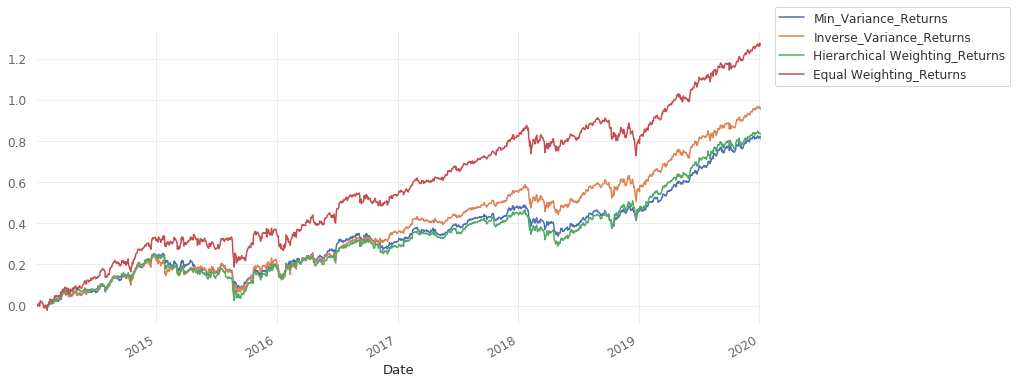

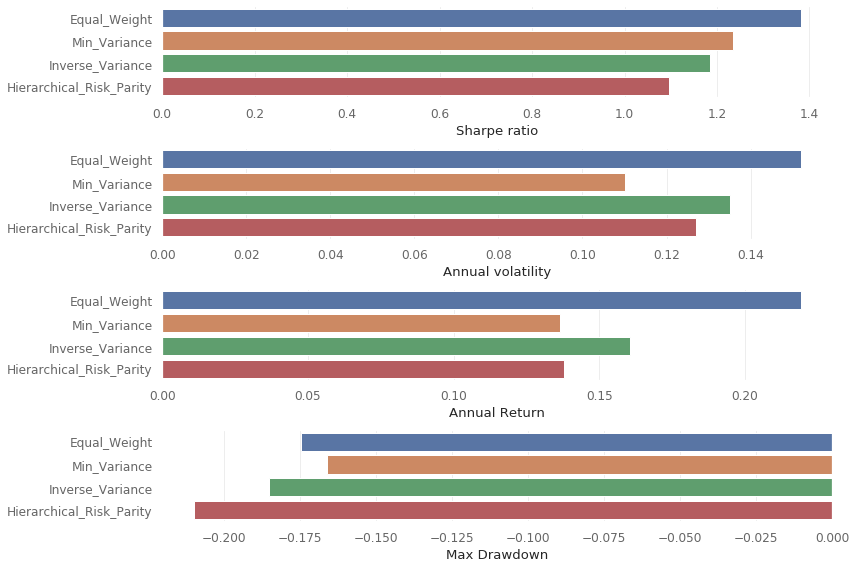

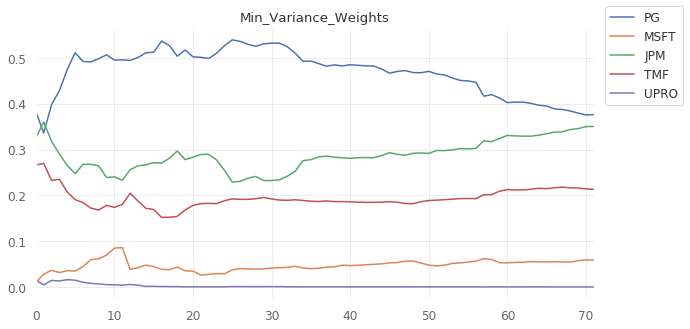

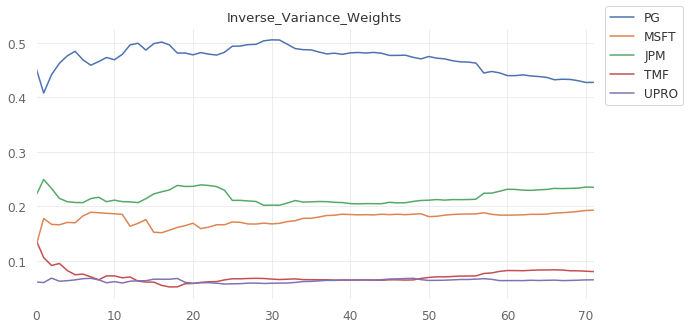

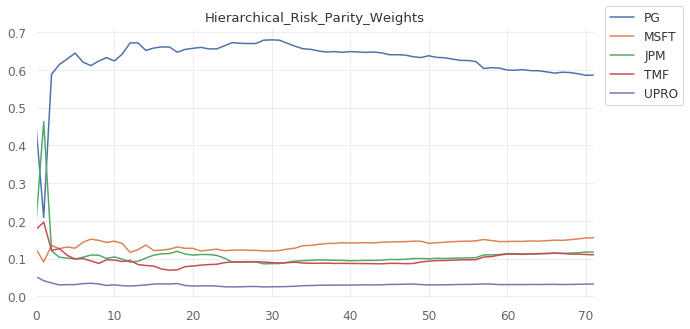

In [19]:
port_returns1 = pd.concat([final_res, data1, data2, data3], axis=1)
port_returns1.columns = ['Equal_Weight', 'Min_Variance', 'Inverse_Variance', 'Hierarchical_Risk_Parity']

plt.figure(figsize=(13,6))
data1.cumsum().plot(label='Min_Variance_Returns')
data2.cumsum().plot(label='Inverse_Variance_Returns')
data3.cumsum().plot(label='Hierarchical Weighting_Returns')
final_res.cumsum().plot(label='Equal Weighting_Returns')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

fig, axs = plt.subplots(nrows=4, figsize=(12, 8))
colors = sns.color_palette(palette='Set3', n_colors=len(port_returns))

sharpes = port_returns1.apply(pf.timeseries.sharpe_ratio)
sns.barplot(x=sharpes.values, y=sharpes.index, ax=axs[0])
axs[0].set(xlabel='Sharpe ratio')

vols = port_returns1.apply(pf.timeseries.annual_volatility)
sns.barplot(x=vols.values, y=vols.index, ax=axs[1])
axs[1].set(xlabel='Annual volatility')

aret = port_returns1.apply(pf.timeseries.annual_return)
sns.barplot(x=aret.values, y=aret.index, ax=axs[2])
axs[2].set(xlabel='Annual Return')
fig.tight_layout()

mdd = port_returns1.apply(pf.timeseries.max_drawdown)
sns.barplot(x=mdd.values, y=mdd.index, ax=axs[3])
axs[3].set(xlabel='Max Drawdown')
fig.tight_layout()
plt.show();

wt1.plot(figsize=(10,5))
plt.title('Min_Variance_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt2.plot(figsize=(10,5))
plt.title('Inverse_Variance_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

wt3.plot(figsize=(10,5))
plt.title('Hierarchical_Risk_Parity_Weights')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

In [20]:
qs.extend_pandas()

stock = data11

In [21]:
stock[:5]

Date
2014-02-03   -0.002278
2014-02-04   -0.001658
2014-02-05   -0.004365
2014-02-06    0.006669
2014-02-07    0.003936
dtype: float64

In [23]:
qs.reports.html(stock, "SPY", title='PG-MSFT-JPM-TMF-UPRO_Min_Var_Sld_Wndw')